# Практическая работа № 1
### Предварительная обработка данных
### Самарин Никита КИ21-17/2Б
# Цель: 
Знакомство с основными задачами предварительной
обработки исходных данных, изучение основных методов
предварительной обработки данных, формирование навыков
выполнения предварительной обработки исходных данных с
помощью языка программирования Python.
# Задание
Общая последовательность действий
1. Визуальный анализ данных
2. Провести проверку правдоподобности исходных данных
3. Поиск аномальных значений
4. Поиск и восстановление пропущенных значений
5. Преобразование данных

Вариант 17
Столбцы: cat16_city, cat4_income, num1_18, num2_18, num3_18

# Ход работы

In [157]:
import pandas as pd
import numpy as np
import scipy
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import plots
import anomalies_found

#from sklearn.linear_model
#from sklearn.neighbors
from sklearn.naive_bayes import GaussianNB
#from sklearn.discriminant_analysis import
#from sklearn.svm import
#from sklearn.model_selection import
#from sklearn.feature_selection import
#from imblearn (оверсэмплинг, андерсэмплинг)
#from sklearn.metrics

%matplotlib inline


In [158]:
cat_atributes = ['cat16_city', 'cat4_income']
num_attributes = ['num1_18', 'num2_18', 'num3_18']
dataframe = pd.read_excel("first_practice_dataframe.xlsx", usecols = cat_atributes + num_attributes)
dataframe.head()

,cat4_income,cat16_city,num1_18,num2_18,num3_18
0,"$40,001 - $50,000",moscow,847.017402,165.688608,284.304766
1,"$40,001 - $50,000",St. Petersburg,777.364074,NaN,320.926465
2,"$40,001 - $50,000",St. Petersburg,681.206564,-151.596727,411.846997
3,"Below $30,001",Moscow,892.652096,713.293102,410.483469
4,-,Chelyabinsk,739.593504,624.333338,474.096709


## 1. Визуальный анализ данных:

Диаграмма по столбцу num3_18  не может быть построена


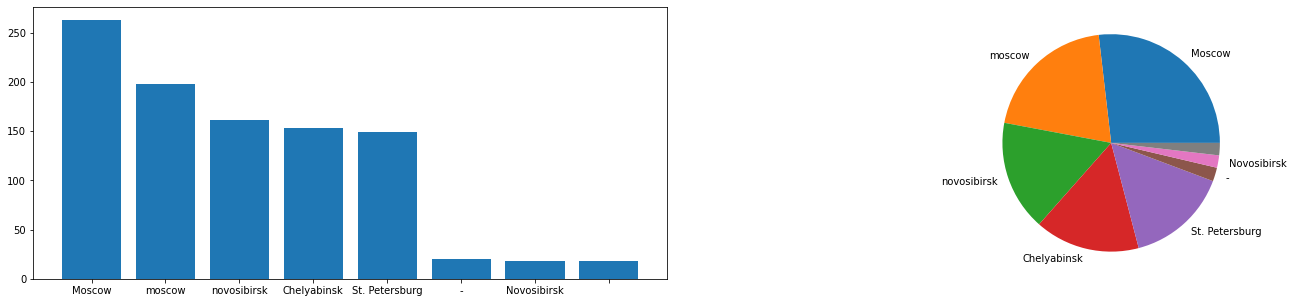

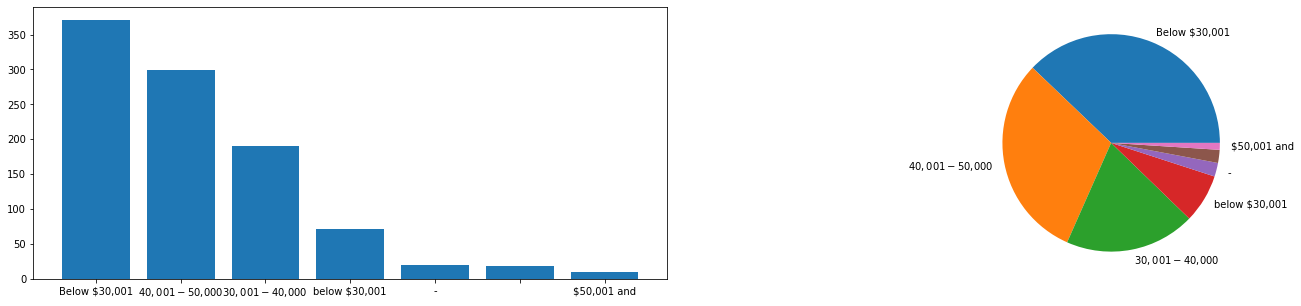

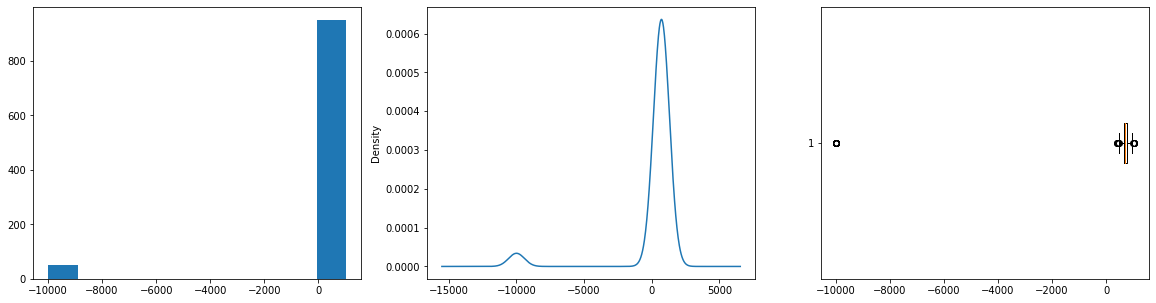

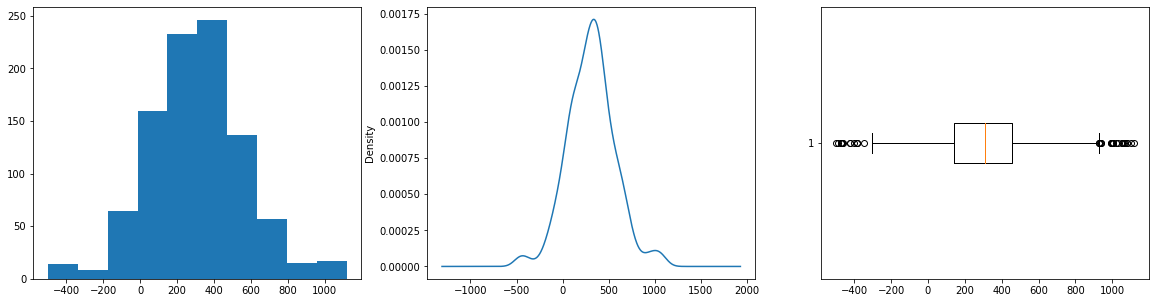

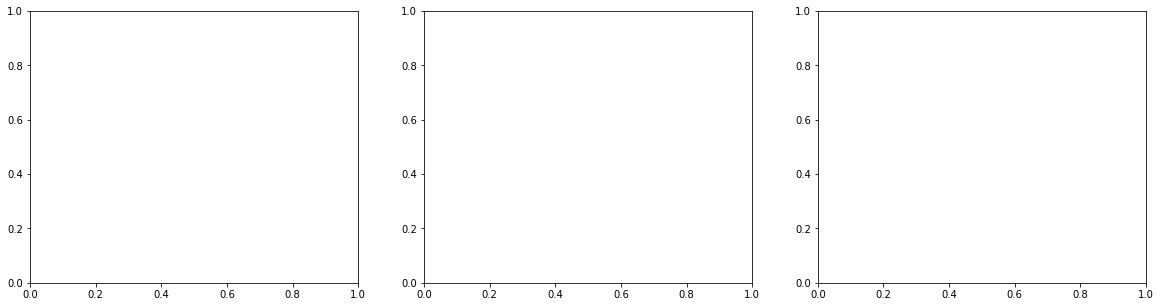

In [159]:
plots.build_cat_plots(dataframe, cat_atributes)
for i in num_attributes:
    try:
        plots.build_num_plots(dataframe, i)
    except TypeError:
        print("Диаграмма по столбцу", i, " не может быть построена")

Из-за не числовых данных, диаграммы столбца num3_18 не могут быть построены

## 2. Провести проверку правдоподобности исходных данных:

Найдём все уникальные не числовые значения

In [160]:
print(dataframe[cat_atributes[0]].unique())
print(dataframe[cat_atributes[1]].unique())
print(dataframe[num_attributes][dataframe.apply(pd.to_numeric, errors="coerce").isna()].stack().unique())

['moscow' 'St. Petersburg' 'Moscow' 'Chelyabinsk' 'novosibirsk' nan '-'
 'Novosibirsk' ' ']
['$40,001 - $50,000' 'Below $30,001' '-' '$30,001 - $40,000 ' ' '
 'below $30,001' nan '$50,001 and']
[' ' '-']


Приведём найденные неправильные значения к нужному формату

In [161]:
dataframe[cat_atributes] = dataframe[cat_atributes].applymap(lambda x: x.capitalize() if isinstance(x, float) == False else x)
dataframe[cat_atributes] = dataframe[cat_atributes].replace([' ', '-', np.nan], None)
dataframe[num_attributes] = dataframe[num_attributes].apply(pd.to_numeric, errors="coerce")

Проверим все уникальные не числовые значения

In [162]:
print(dataframe[cat_atributes[0]].unique())
print(dataframe[cat_atributes[1]].unique())
print(dataframe[num_attributes][dataframe.apply(pd.to_numeric, errors="coerce").isna()].stack().unique())

['Moscow' 'St. petersburg' 'Chelyabinsk' 'Novosibirsk' None]
['$40,001 - $50,000' 'Below $30,001' None '$30,001 - $40,000 '
 '$50,001 and']
[]


## 3. Поиск аномальных значений

Метод квартилей

In [163]:
df_quartile_method = dataframe.copy(deep = True)
for i in num_attributes:
    df_quartile_method = anomalies_found.quartile_method(df_quartile_method, i)

Границы для num1_18 465.7757149523141 965.6282520845275
Границы для num2_18 -313.43931404033526 905.7478961411771
Границы для num3_18 36.982528448338826 685.0250553805574


Метод сигм

In [164]:
for i in num_attributes:
    dataframe = anomalies_found.sigma_method(dataframe, i)
dataframe = dataframe.reset_index(drop = True)

Границы для num1_18 616.1519643298275 828.7355481697302
Границы для num2_18 -17.225994799513046 586.0681099782721
Границы для num3_18 177.05781487995415 544.2705726873253


Ящики с усами для данных полученных после применения метода квартилей и метода сигм:

num1_18       Axes(0.125,0.125;0.227941x0.755)
num2_18    Axes(0.398529,0.125;0.227941x0.755)
num3_18    Axes(0.672059,0.125;0.227941x0.755)
dtype: object

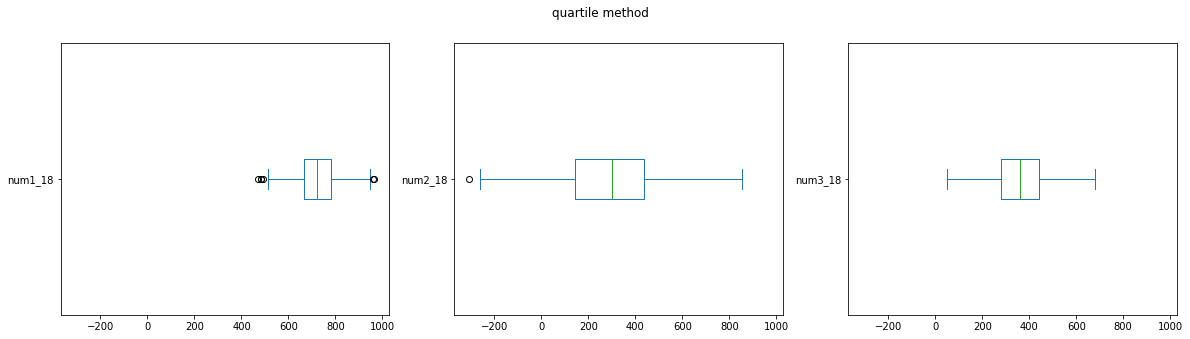

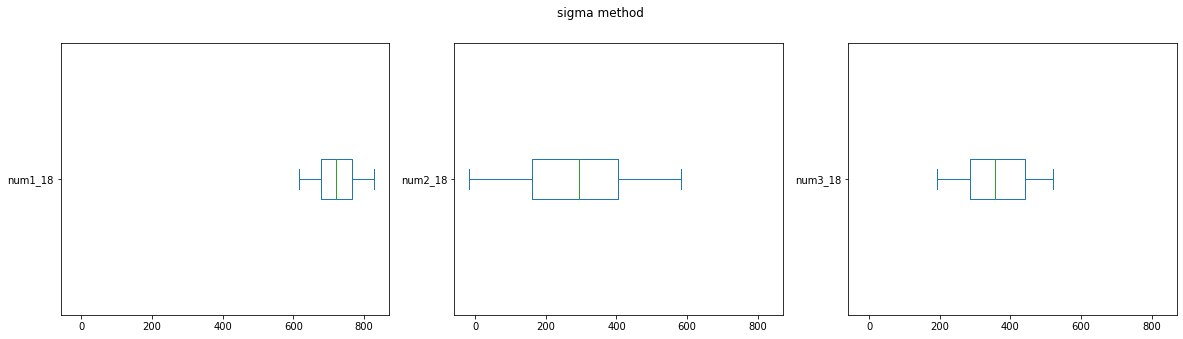

In [165]:
df_quartile_method.plot.box(subplots = True, figsize=(20, 5), title="quartile method", vert=False)
dataframe.plot.box(subplots = True, figsize=(20, 5), title="sigma method", vert=False)

"Границы значений" полученные при помощи метода квартилей шире чем полученные методом сигм, метод сигм удалил больше строк с выбросами значениями

## 4. Поиск и восстановление пропущенных значений:

Подсчёт пропусков

In [166]:
print(dataframe.isnull().sum())

cat4_income    32
cat16_city     32
num1_18         0
num2_18        36
num3_18        50
dtype: int64


Для первого признака для восстановления пропусков используем метод 𝑘-ближайших соседей. Так как первый признак это текстовый столбец, сначала закодируем его, после восстановления пропусков раскодируем закодированные значения.

In [167]:
encoder = LabelEncoder()
dataframe[cat_atributes[0]] = encoder.fit_transform(dataframe[cat_atributes[0]])
none_label = encoder.transform([None])[0]
dataframe[cat_atributes[0]].replace(none_label, None, inplace = True)

dataframe_copy = dataframe.copy(deep = True)
imputer = KNNImputer(n_neighbors=5, weights="distance")
df_without_nan = imputer.fit_transform(dataframe_copy[[cat_atributes[0], num_attributes[0], num_attributes[1], num_attributes[2]]])
dataframe[cat_atributes[0]] = df_without_nan[:,0]

dataframe[cat_atributes[0]] = dataframe[cat_atributes[0]].apply(lambda x: round(x) if round(x) != none_label else (round(x) if round(x) != none_label else round(x) + 1))
dataframe[cat_atributes[0]] = encoder.inverse_transform(dataframe[cat_atributes[0]])

Для второго пропущенные значения заменим самым популярным значением.

In [168]:
dataframe = dataframe.replace({cat_atributes[1]:{np.nan:dataframe.cat4_income.mode()}})

Для третьего используем среднее значение.

In [169]:
dataframe = dataframe.replace({num_attributes[0]:{np.nan:dataframe.num1_18.mean()}})

 Для четвертого – медиану.

In [170]:

dataframe = dataframe.replace({num_attributes[1]:{np.nan:dataframe.num2_18.median()}})

Для пятого – метод 𝑘-ближайших соседей

In [171]:

imputer = KNNImputer(n_neighbors=5, weights="distance")
numeric_dataframe = dataframe[num_attributes]
numeric_dataframe = pd.DataFrame(imputer.fit_transform(numeric_dataframe), columns=numeric_dataframe.columns)
dataframe.num3_18 = numeric_dataframe[[num_attributes[2]]]

In [172]:
print(dataframe.isnull().sum())

cat4_income    0
cat16_city     0
num1_18        0
num2_18        0
num3_18        0
dtype: int64


Подсчёт пропусков

## 5. Преобразование данных:

Стандартизируем числовые столбцы и добавим их в датафрем

In [173]:
scaler = StandardScaler()
for i in num_attributes:
    numeric_dataframe = dataframe[[i]]
    numeric_dataframe = scaler.fit_transform(numeric_dataframe)
    dataframe[i + "_stand"] = numeric_dataframe

Нормализуем числовые столбцы и добавим их в датафрейм

In [174]:
scaler = MinMaxScaler()
for i in num_attributes:
    numeric_dataframe = dataframe[[i]]
    numeric_dataframe = scaler.fit_transform(numeric_dataframe)
    dataframe[i + "_norm"] = numeric_dataframe

Первый текстовый столбец закодируем через one-hot encoding.

In [175]:
encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(dataframe[[cat_atributes[0]]]).toarray(), columns=encoder.get_feature_names_out([cat_atributes[0]]))
dataframe = pd.concat([encoder_df, dataframe], axis=1, join='inner')

Второй текстовый столбец закодируем через  label encoding.

In [176]:
encoder = LabelEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(dataframe[cat_atributes[1]]), columns=[cat_atributes[1] + "_encoded"])
dataframe = pd.concat([encoder_df, dataframe], axis=1, join='inner')
print("Полученные кодировки:", {l: i for i, l in enumerate(encoder.classes_)})

Полученные кодировки: {'$30,001 - $40,000 ': 0, '$40,001 - $50,000': 1, '$50,001 and': 2, 'Below $30,001': 3}


Кодировка столбцов прошла успешно:

In [177]:
dataframe.head()

,cat4_income_encoded,cat16_city_Chelyabinsk,cat16_city_Moscow,cat16_city_Novosibirsk,cat16_city_St. petersburg,cat4_income,cat16_city,num1_18,num2_18,num3_18,num1_18_stand,num2_18_stand,num3_18_stand,num1_18_norm,num2_18_norm,num3_18_norm
0,1,0.0,0.0,0.0,1.0,"$40,001 - $50,000",St. petersburg,777.364074,294.160747,320.926465,1.008198,0.064279,-0.452181,0.759515,0.519251,0.394302
1,3,1.0,0.0,0.0,0.0,"Below $30,001",Chelyabinsk,806.591088,294.160747,302.198953,1.551268,0.064279,-0.662966,0.897292,0.519251,0.337404
2,0,0.0,0.0,0.0,1.0,"$30,001 - $40,000",St. petersburg,809.257303,339.137340,395.942820,1.600809,0.371439,0.392156,0.909860,0.594469,0.622221
3,3,0.0,0.0,0.0,1.0,"Below $30,001",St. petersburg,743.121738,321.678993,218.600451,0.371939,0.252210,-1.603898,0.598095,0.565272,0.083411
4,1,1.0,0.0,0.0,0.0,"$40,001 - $50,000",Chelyabinsk,688.954830,183.072722,472.313304,-0.634541,-0.694377,1.251734,0.342750,0.333470,0.854253


Графики нормализованых столбцов

In [178]:
for i in num_attributes:
    print("Границы для нормализованного столбца", i + "_norm", dataframe[i + "_norm"].min(), dataframe[i + "_norm"].max())

Границы для нормализованного столбца num1_18_norm 0.0 1.0000000000000004
Границы для нормализованного столбца num2_18_norm 0.0 1.0
Границы для нормализованного столбца num3_18_norm 0.0 1.0


Графики стандартизированных столбцов

In [179]:
for i in num_attributes:
    print("Среднее и дисперсия для стандартизованного столбца", i + "_stand", dataframe[i + "_stand"].mean(), dataframe[i + "_stand"].std(ddof=0))

Среднее и дисперсия для стандартизованного столбца num1_18_stand 7.985814738531828e-17 0.9999999999999999
Среднее и дисперсия для стандартизованного столбца num2_18_stand -3.5838778338776984e-17 1.0
Среднее и дисперсия для стандартизованного столбца num3_18_stand -2.6801173366389743e-16 1.0


## Вывод

Данные были предобработаны. Диаграммы по получившемся данным:

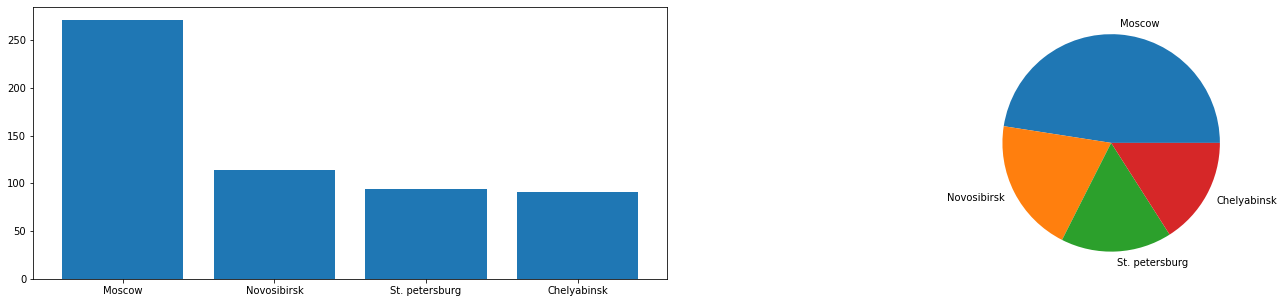

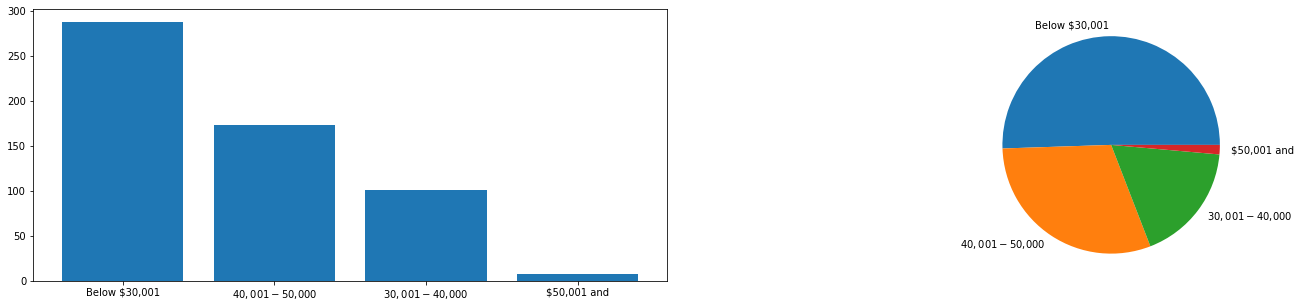

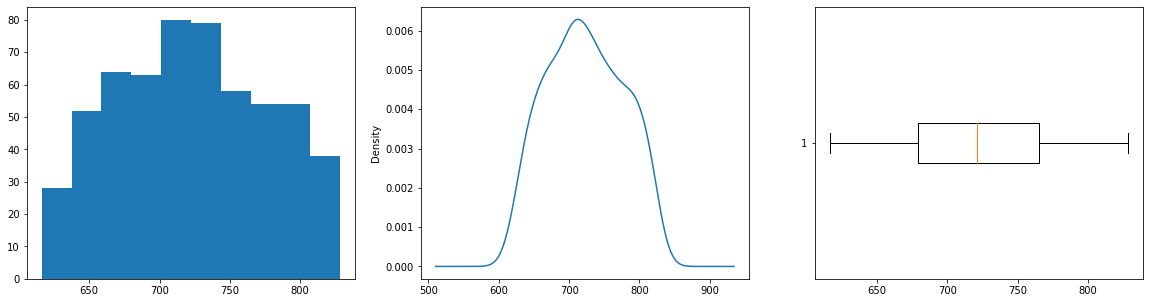

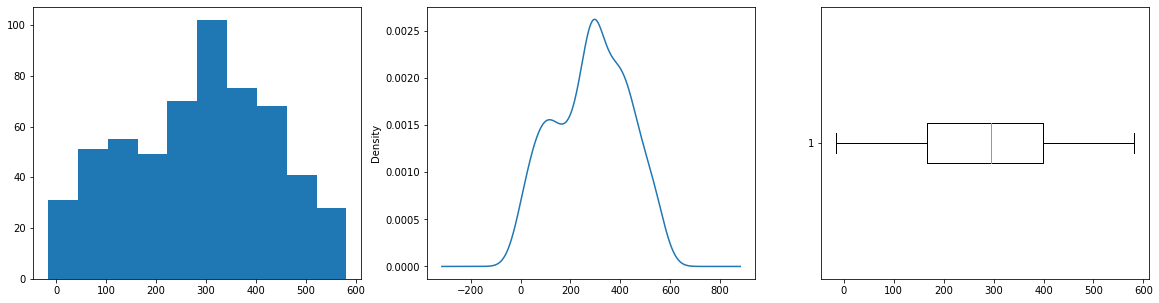

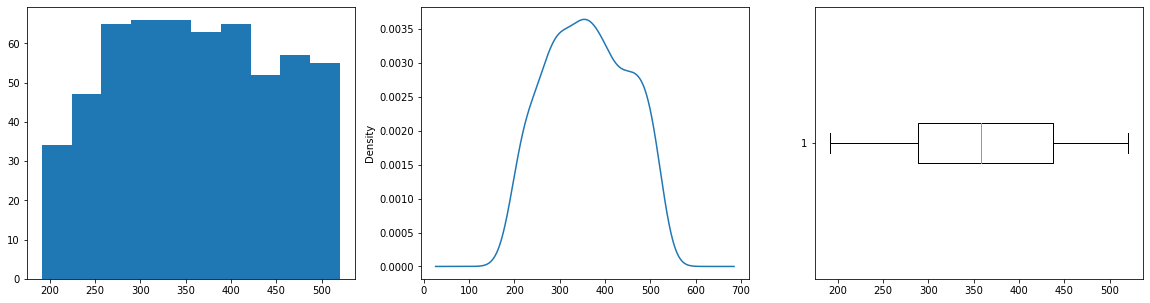

In [180]:
plots.build_cat_plots(dataframe, cat_atributes)
for i in num_attributes:
    plots.build_num_plots(dataframe, i)
